/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6518 - loss: 0.7169 - val_accuracy: 0.7642 - val_loss: 0.5489
Epoch 2/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7561 - loss: 0.5509 - val_accuracy: 0.7857 - val_loss: 0.5160
Epoch 3/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7746 - loss: 0.5186 - val_accuracy: 0.7539 - val_loss: 0.5491
Epoch 4/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7860 - loss: 0.4934 - val_accuracy: 0.7891 - val_loss: 0.4835
Epoch 5/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7907 - loss: 0.4793 - val_accuracy: 0.7959 - val_loss: 0.4780
Epoch 6/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8044 - loss: 0.4587 - val_accuracy: 0.8138 - val_loss: 0.4434
Epoch 7/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8096 - loss: 0.4439 - val_accuracy: 0.8127 - val_loss: 0.4348
Epoch 8/150
3030/3030 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8166 -

1515/1515 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8871 - loss: 0.2797
Test Accuracy: 0.8876281380653381
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Accuracy: 0.8876281641326099
Predicted Class: 2, Actual Class: 2
Predicted Class: 1, Actual Class: 1
Enter the crop you want to visualize (e.g., 'Rice'): Rice


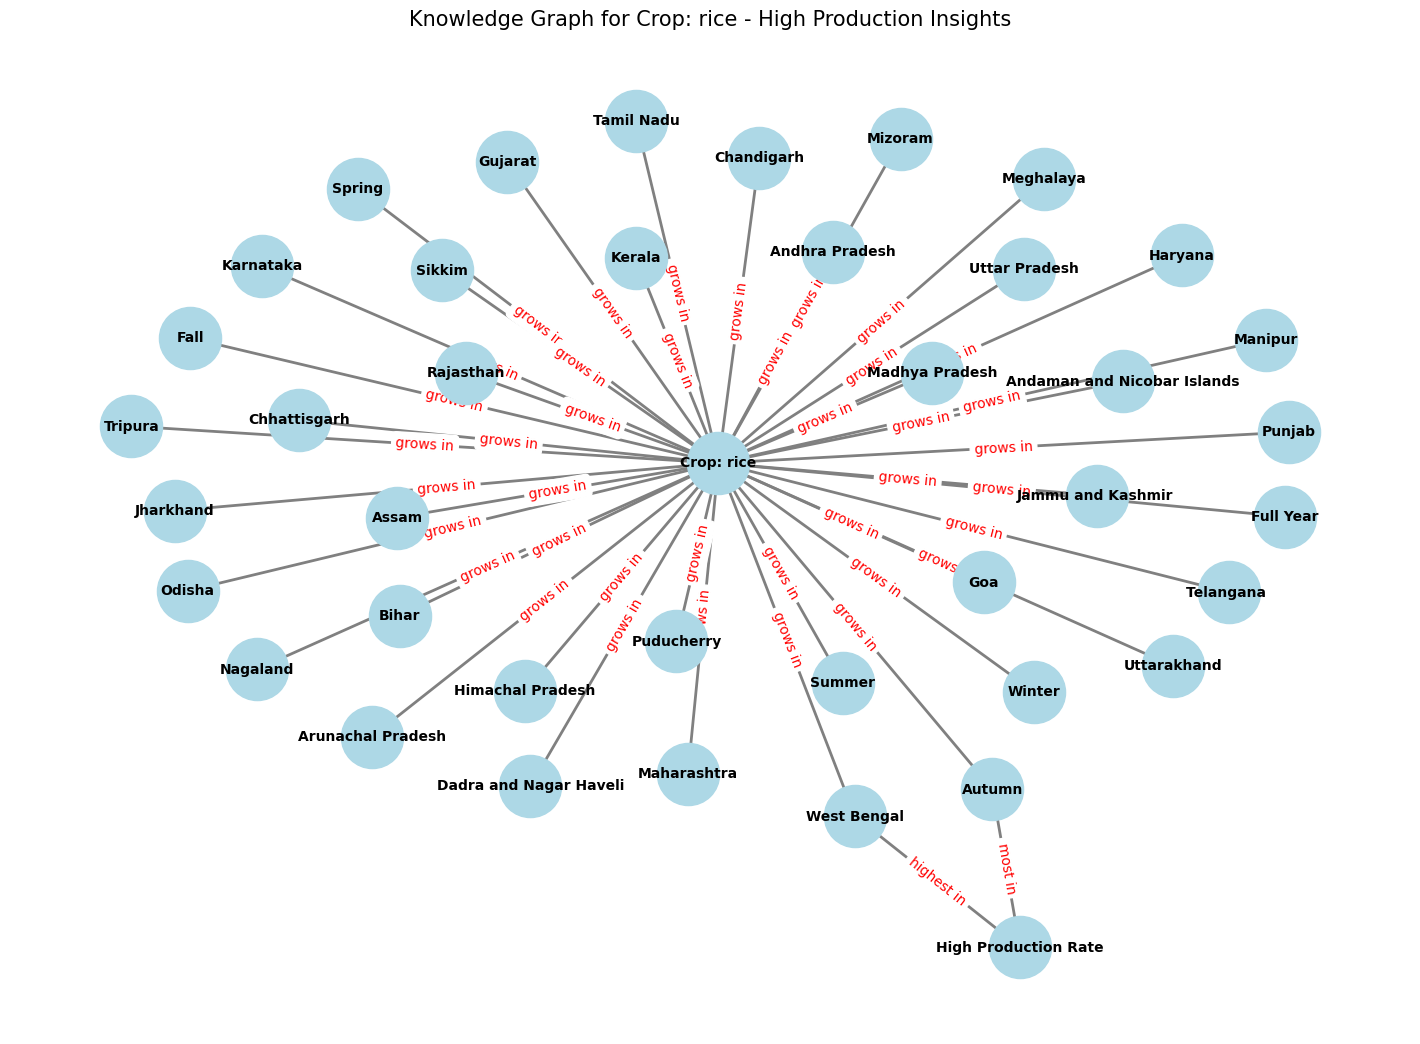

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Load the dataset
file_path = r"/content/Crop_Production_know_graph.csv"
data = pd.read_csv(file_path)

# Drop or fill missing values
data = data.dropna()

# Convert the 'Crop' column to lowercase to handle case insensitivity
data['Crop'] = data['Crop'].str.lower()

# Encode categorical variables 'Crop', 'Season2', 'State_Name', 'District_Name'
label_encoder_crop = LabelEncoder()
data['Crop'] = label_encoder_crop.fit_transform(data['Crop'])

label_encoder_season = LabelEncoder()
data['Season2'] = label_encoder_season.fit_transform(data['Season2'])

label_encoder_state = LabelEncoder()
data['State_Name'] = label_encoder_state.fit_transform(data['State_Name'])

label_encoder_district = LabelEncoder()
data['District_Name'] = label_encoder_district.fit_transform(data['District_Name'])

# Create classes based on production rate quantiles
data['Production_Class'] = pd.qcut(data['Production Rate'], q=3, labels=[0, 1, 2])

# Features and target
X = data[['Crop', 'Season2', 'Area', 'Crop_Year', 'State_Name', 'District_Name']]
y = data['Production_Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# One-hot encode the target variable for multi-class classification
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the multi-class classification model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model
model.save('crop_production_multi_class_model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate classification accuracy
acc = accuracy_score(y_test_classes, y_pred_classes)
print(f"Classification Accuracy: {acc}")

# Print some predictions and their corresponding actual values
for i in range(2):
    print(f"Predicted Class: {y_pred_classes[i]}, Actual Class: {y_test_classes[i]}")

# User Input for Specific Crop
user_crop_input = input("Enter the crop you want to visualize (e.g., 'Rice'): ").strip().lower()

# Try encoding the input crop
try:
    user_crop_encoded = label_encoder_crop.transform([user_crop_input])[0]
except ValueError:
    print("The crop you entered is not in the dataset. Please try again.")
    exit()

# Filter the data for the specific crop
data_filtered = data[data['Crop'] == user_crop_encoded]

# Determine the state with the highest production for the crop
highest_production_state = data_filtered.groupby('State_Name')['Production Rate'].sum().idxmax()
highest_production_state_name = label_encoder_state.inverse_transform([highest_production_state])[0]

# Determine the season with the highest production for the crop
highest_production_season = data_filtered.groupby('Season2')['Production Rate'].sum().idxmax()
highest_production_season_name = label_encoder_season.inverse_transform([highest_production_season])[0]

# Knowledge Graph for the specified crop with highest production state and season
G = nx.Graph()

# Add main crop node
G.add_node(f"Crop: {user_crop_input}", size=5000)

# Add nodes for all states and seasons related to the crop
for _, row in data_filtered.iterrows():
    state_name = label_encoder_state.inverse_transform([row['State_Name']])[0]
    season_name = label_encoder_season.inverse_transform([row['Season2']])[0]

    # Add state and season nodes
    G.add_node(state_name, size=3000)
    G.add_node(season_name, size=3000)

    # Add edges to represent relationships
    G.add_edge(f"Crop: {user_crop_input}", state_name, label="grows in")
    G.add_edge(f"Crop: {user_crop_input}", season_name, label="grows in")

# Highlight edges for highest production state and season
G.add_node("High Production Rate", size=3000)
G.add_edge("High Production Rate", highest_production_state_name, label="highest in")
G.add_edge("High Production Rate", highest_production_season_name, label="most in")

# Visualization customization
pos = nx.spring_layout(G, k=0.5, seed=42)

plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray", width=2)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

# Title for the graph
plt.title(f"Knowledge Graph for Crop: {user_crop_input} - High Production Insights", fontsize=15)
plt.show()
